In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
x = torch.linspace(-1,1,20)
ep = torch.rand(x.shape)*0.1
y = x**2+ep

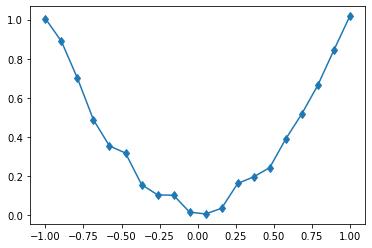

In [4]:
plt.plot(x,y, 'd-')

In [5]:
n = 20
layers = []
layers.append(nn.Linear(1,n))
layers.append(nn.ReLU())
layers.append(nn.Linear(n,n))
layers.append(nn.ReLU())
layers.append(nn.Linear(n,1))

mlp = nn.Sequential(*layers)

In [6]:
xb, yb = x[:, None], y[:, None]
print(x.shape, xb.shape)

torch.Size([20]) torch.Size([20, 1])


In [7]:
yprime = mlp(xb)
yprime.shape

torch.Size([20, 1])

In [8]:
yprime2 = yprime.squeeze().detach()

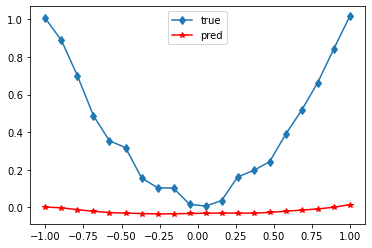

In [9]:
plt.plot(x,y, 'd-', label = 'true')
plt.plot(x, yprime2, '*r-', label= 'pred')
plt.legend()

In [10]:
loss = F.mse_loss(yb,yprime )
loss

tensor(0.2845, grad_fn=<MeanBackward0>)

In [11]:
loss.backward()

In [12]:
lr  = 1e-1
for name, param in mlp.named_parameters():
#     print(param)
    param.data = param.data - param.grad*lr

In [13]:
mlp.zero_grad()

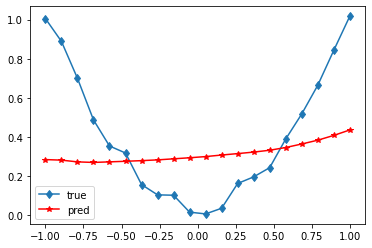

In [14]:
yprime = mlp(xb)
yprime2 = yprime.squeeze().detach()
plt.plot(x,y, 'd-', label = 'true')
plt.plot(x, yprime2, '*r-', label= 'pred')
plt.legend()

# loop 

In [15]:
epochs = 100
for i in range(epochs):
    yprime = mlp(xb)
    loss = F.mse_loss(yb,yprime )
    loss.backward()
    lr  = 1e-1
    for name, param in mlp.named_parameters():
        param.data = param.data - param.grad*lr
    mlp.zero_grad()

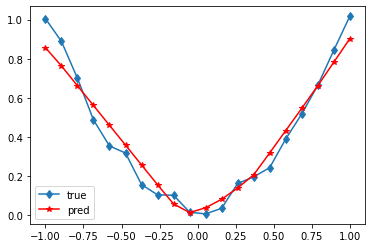

In [16]:
yprime = mlp(xb)
yprime2 = yprime.squeeze().detach()
plt.plot(x,y, 'd-', label = 'true')
plt.plot(x, yprime2, '*r-', label= 'pred')
plt.legend()

In [17]:
x2 = torch.linspace(-1,1,200)
x2b = x2[:, None]

In [18]:
y2prime = mlp(x2b)

In [19]:
y2prime_2 = y2prime.squeeze().detach()

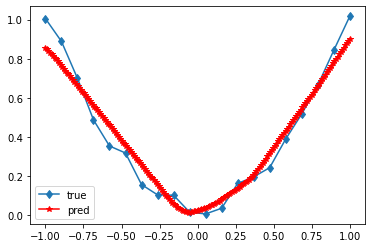

In [20]:
plt.plot(x,y, 'd-', label = 'true')
plt.plot(x2, y2prime_2, '*r-', label= 'pred')
plt.legend()

# Starting here

In [21]:
def make_mlp(n = 20, layers_count = 3):
    layers = []
    layers.append(nn.Linear(1,n))
    layers.append(nn.ReLU())
    for i in range(layers_count -2):
        layers.append(nn.Linear(n,n))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(n,1))
    mlp = nn.Sequential(*layers)
    return mlp

In [22]:
mlp = make_mlp(100, 4)

In [23]:
mlp

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=1, bias=True)
)

In [24]:
def do_step(my_mlp, lr = 1e-1):
    yprime = my_mlp(xb)
    loss = F.mse_loss(yb,yprime )
    loss.backward()
    for name, param in my_mlp.named_parameters():
        param.data = param.data - param.grad*lr
    my_mlp.zero_grad()
    return yprime.squeeze().detach()

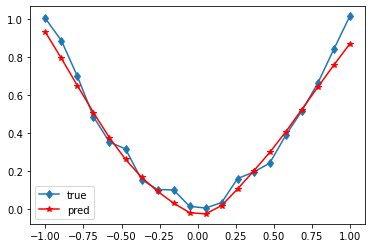

In [25]:
for i in range(100):
    yprime_out = do_step(mlp)

plt.plot(x,y, 'd-', label = 'true')
plt.plot(x, yprime_out, '*r-', label= 'pred')
plt.legend()

# Show an animiation

In [26]:
# from matplotlib.animation import FuncAnimation
# from IPython import display

# fig = plt.figure()
# ax = plt.axes(xlim=(-1.1, 1.1), ylim = (-0.2, 1.5))
# line, = ax.plot([], [], 'd-', label = 'pred')
# ax.plot(x,y, 'd-', label = 'true')
# ax.legend()

# def frame_function(frame_num, mlp):
#     if frame_num % 50 ==0: print(f"On frame {frame_num}")
#     yprime_out = do_step(mlp)
#     line.set_data(x,yprime_out)

# mlp = make_mlp(100, 4)
# anim = FuncAnimation(fig, frame_function, fargs = (mlp, ), frames = 300, interval = 20, blit = False)

# video = anim.to_html5_video()

# html = display.HTML(video)
# display.display(html)

# mlp = make_mlp(100,5)
# anim = FuncAnimation(fig, frame_function, fargs=(mlp,) , frames=500, interval=10, blit=False)
# anim.save('myanim.gif')

In [30]:
def mish(input):
    return input * torch.tanh(F.softplus(input))

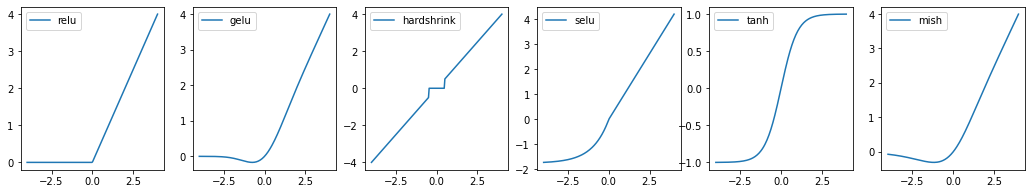

In [28]:
fns = [F.relu, F.gelu, F.hardshrink, F.selu,torch.tanh , mish]
x = torch.linspace(-4,4,200)
n = len(fns)
b = 3
fig, ax = plt.subplots(1,n, figsize = (b*n,b))
for i,f in enumerate(fns):
    y = f(x)
    name = f"{f.__name__}"
#     name = f"{i}"
    ax[i].plot(x,y, label =name)
    ax[i].legend()

In [29]:
class Stepper:
    clear_grad = True
    def __call__(self,my_mlp,xb, yb, lr = 1e-1):
        yprime = my_mlp(xb)
        loss = F.mse_loss(yb,yprime )
        loss.backward()
        for name, param in my_mlp.named_parameters():
            param.data = param.data - param.grad*lr
        if self.clear_grad: my_mlp.zero_grad()
        self.yprime = yprime
        return yprime.squeeze().detach()

In [31]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, _input):
        return mish(_input)

In [32]:
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, _input):
        return torch.sin(_input)

In [33]:
def make_batch(x): return x[:,None]

def debatch(x, detach = True):
    x =  x.squeeze()
    if detach: x = x.detach()
    return x

In [34]:
x = torch.linspace(-1,1,20)
ep = torch.rand_like(x)*0.1
y = x**2 - 0.5 +ep

In [35]:
xb,yb = [make_batch(z) for z in [x,y]]

In [36]:
def make_mlp(n = 20, layers_count = 3, act = Mish):
#     act = Sine # torch.ReLU
#     act = Mish # torch.ReLU
#     act = nn.GELU
#     act = nn.ReLU
#     act = nn.SELU
#     act = nn.Tanh
    layers = []
    layers.append(nn.Linear(1,n))
    layers.append(act())
    for i in range(layers_count -2):
        layers.append(nn.Linear(n,n))
        layers.append(act())
    layers.append(nn.Linear(n,1))
    mlp = nn.Sequential(*layers)
    return mlp

In [37]:
# xb
xb.requires_grad = True
yprime = mlp(xb)


In [38]:
dydx = torch.autograd.grad(yprime.sum(), xb, create_graph=True )[0]

In [39]:
d2yd2x = torch.autograd.grad(dydx.sum(), xb, create_graph=True )[0]

In [40]:
do_step = Stepper()

In [41]:
mlp = make_mlp()

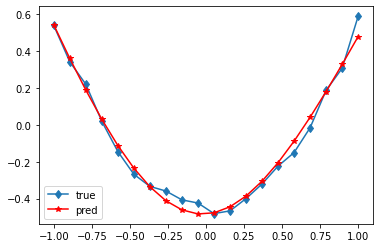

In [42]:


for i in range(300):
    yprime_out = do_step(mlp,xb,yb,lr = 1e-1)

plt.plot(x,y, 'd-', label = 'true')
plt.plot(x, yprime_out, '*r-', label= 'pred')
plt.legend()

In [43]:
yprime = mlp(xb)
dydx = torch.autograd.grad(yprime.sum(), xb, create_graph=True )[0]
d2yd2x = torch.autograd.grad(dydx.sum(), xb, create_graph=True )[0]

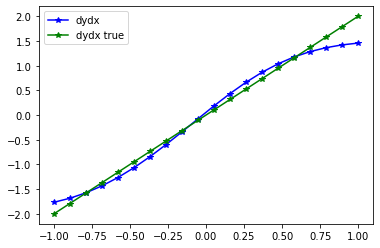

In [44]:
analytical_dydx = 2*x
# plt.plot(x, yprime_out, '*r-', label= 'pred')
plt.plot(x, debatch(dydx), '*b-', label= 'dydx')
plt.plot(x, analytical_dydx, '*g-', label= 'dydx true')
plt.legend()


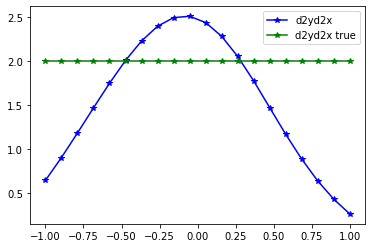

In [45]:
analytical_dy2dx2 = 0*x+2
# plt.plot(x, yprime_out, '*r-', label= 'pred')
plt.plot(x, debatch(d2yd2x), '*b-', label= 'd2yd2x')
plt.plot(x, analytical_dy2dx2, '*g-', label= 'd2yd2x true')
plt.legend()

In [46]:
# yprime

In [47]:
from dataclasses import dataclass

@dataclass
class model_results:
    name:str
    y_l1:float
    dydx_l1:float
    d2yd2x_l1:float

In [48]:
import pandas as pd
# from inspect import signature

In [49]:
def CreateDFWithAttBasedOnObjs(listOfObjects, attributesToSave):
    """Creates a dataframe by extracting the attributes from the objects in the list of objects"""
    df = pd.DataFrame()
    for a in attributesToSave:
        df[a]=[getattr(t,a) for t in listOfObjects]
    return df  

In [50]:
#     act = Sine # torch.ReLU
#     act = Mish # torch.ReLU
#     act = nn.GELU
#     act = nn.ReLU
#     act = nn.SELU
#     act = nn.Tanh

In [51]:
x = torch.linspace(-1,1,20)
ep = torch.rand_like(x)*0.1
y = x**2 - 0.5

In [52]:
xb,yb = [make_batch(z) for z in [x,y]]

In [53]:
analytical_dydx = 2*xb
analytical_dy2dx2 = 0*xb+2
results_list = []
def to_np(x): return x.detach().numpy()
for fn in [Sine, Mish, nn.GELU, nn.ReLU, nn.SELU, nn.Tanh]:
    mlp = make_mlp(act = fn )
    xb.requires_grad = True
    for i in range(100):
        yprime_out = do_step(mlp,xb,yb,lr = 1e-1)
    yprime = mlp(xb)
    dydx = torch.autograd.grad(yprime.sum(), xb, create_graph=True )[0]
    d2yd2x = torch.autograd.grad(dydx.sum(), xb, create_graph=True )[0]
    y1_l1 = F.l1_loss(yprime, yb)
    dydx_l1 = F.l1_loss(analytical_dydx, d2yd2x)
    d2yd2x_l1 = F.l1_loss(analytical_dy2dx2,d2yd2x )
    result = model_results(fn.__name__, to_np(y1_l1), to_np(dydx_l1), to_np(d2yd2x_l1) )
    results_list.append(result)

In [54]:
df = CreateDFWithAttBasedOnObjs(results_list, ['name','y_l1','dydx_l1','d2yd2x_l1'])

In [55]:
df

,name,y_l1,dydx_l1,d2yd2x_l1
0,Sine,0.17930898,1.0929105,1.3800865
1,Mish,0.19074674,1.3244935,1.4923527
2,GELU,0.22487266,0.98758495,1.6471056
3,ReLU,0.104063645,1.0526316,2.0
4,SELU,0.2508349,1.4947863,1.2024617
5,Tanh,0.12799923,1.4560603,1.4018105


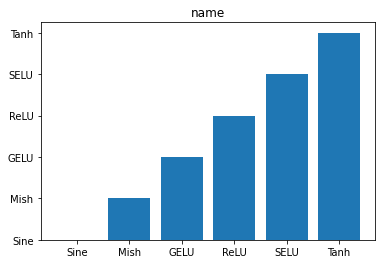

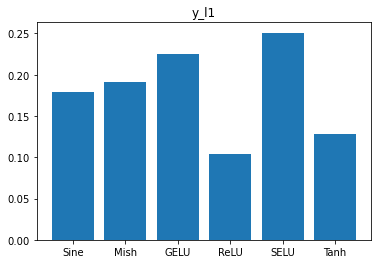

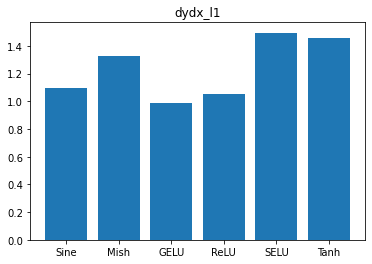

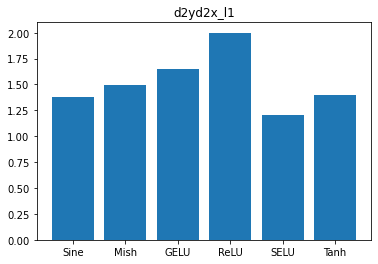

In [56]:
# df.plot.bar(x = 'name')
for c in df.columns:
    x = df['name']
    y = df[c]
    plt.figure()
    plt.bar(x,y)
    ax = plt.gca()
    ax.set_title(c)